<a href="https://colab.research.google.com/github/pranjul6386/Autoencoders/blob/main/Denoising_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! ls "/content/drive/MyDrive/Datasets"

aptos2019-blindness-detection.zip  UTKface_inthewild
denoising-dirty-documents.zip


In [4]:
!unzip "/content/drive/MyDrive/Datasets/denoising-dirty-documents.zip"

Archive:  /content/drive/MyDrive/Datasets/denoising-dirty-documents.zip
  inflating: sampleSubmission.csv.zip  
  inflating: test.zip                
  inflating: train.zip               
  inflating: train_cleaned.zip       


In [ ]:
!unzip "/content/train.zip"
!unzip "/content/test.zip"
!unzip "/content/trained_cleaned.zip"

In [ ]:
!unzip "/content/train_cleaned.zip"

In [41]:
import os
import numpy as np
import PIL.Image
import cv2
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,Flatten,Conv2D,UpSampling2D,Input,MaxPooling2D
from keras.preprocessing.image import load_img,array_to_img,img_to_array
import pandas as pd
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD
from skimage.io import imread, imshow, imsave
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)

540 420


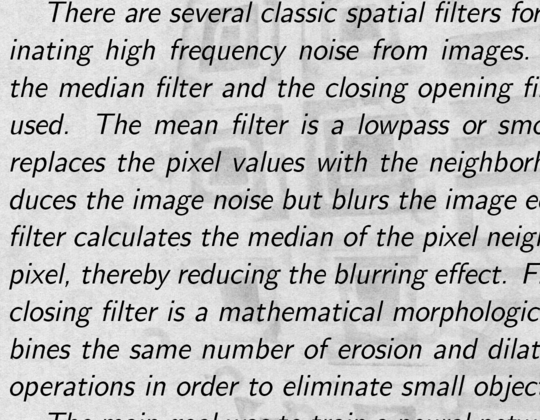

In [7]:
img=PIL.Image.open("/content/train/105.png")
h,w=img.size
print(h,w)
img

540 258


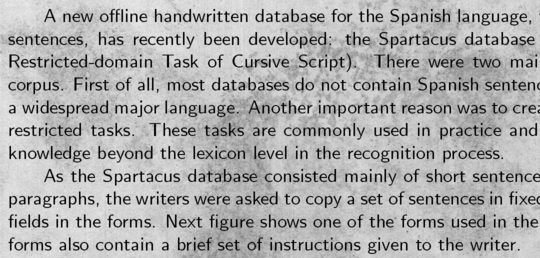

In [9]:
img=PIL.Image.open("/content/test/43.png")
h,w=img.size
print(h,w)
img

540 420


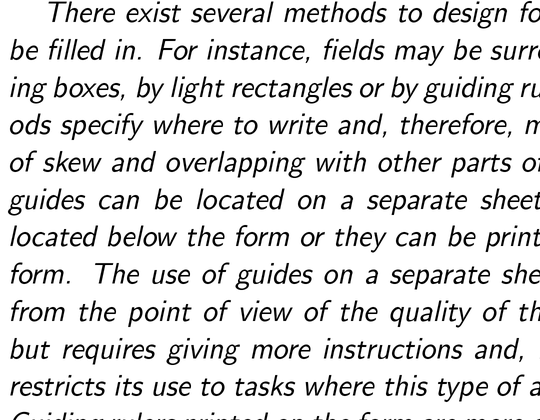

In [12]:
img=PIL.Image.open("/content/train_cleaned/107.png")
h,w=img.size
print(h,w)
img

In [15]:
input_dir=Path("/content/")
train_dir=input_dir/"train"
train_cleaned=input_dir/"train_cleaned"
test_dir=input_dir/"test"

In [16]:
train_dir

PosixPath('/content/train')

In [18]:
train_images=sorted(os.listdir(train_dir))
test_images=sorted(os.listdir(test_dir))
train_labels=sorted(os.listdir(train_cleaned))

In [19]:
print("train images:",len(train_images))
print("train_labels",len(train_labels))
print("test_images",len(test_images))


train images: 144
train_labels 144
test_images 72


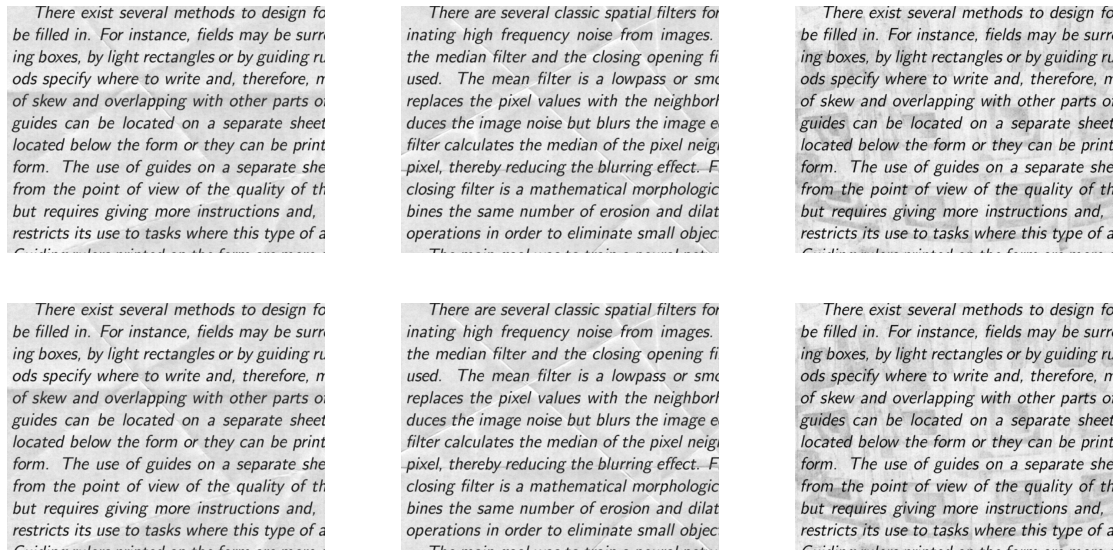

In [23]:
samples=train_images[:3]+train_labels[:3]
fig,axes=plt.subplots(2,3,figsize=(20,10))
for i ,img in enumerate(samples):
  img=imread(train_dir/img)
  axes[i//3, i%3].imshow(img, cmap='gray')
  axes[i//3, i%3].axis('off')
plt.show()

In [42]:
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [43]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 210, 270, 64)      0   

In [36]:
#Load images and labels
Y = []
X=[]

for img in train_images:
    img = load_img(train_dir / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [37]:
#train_test_split....train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)


Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [44]:
autoencoder.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/50
17/17 [==============================] - 135s 8s/step - loss: 0.4742 - val_loss: 0.3550
Epoch 2/50
17/17 [==============================] - 128s 7s/step - loss: 0.3441 - val_loss: 0.3243
Epoch 3/50
17/17 [==============================] - 128s 8s/step - loss: 0.3004 - val_loss: 0.2565
Epoch 4/50
17/17 [==============================] - 127s 7s/step - loss: 0.2454 - val_loss: 0.2364
Epoch 5/50
17/17 [==============================] - 128s 7s/step - loss: 0.2229 - val_loss: 0.2154
Epoch 6/50
17/17 [==============================] - 128s 7s/step - loss: 0.2043 - val_loss: 0.1991
Epoch 7/50
17/17 [==============================] - 127s 7s/step - loss: 0.1854 - val_loss: 0.1856
Epoch 8/50
17/17 [==============================] - 128s 8s/step - loss: 0.1736 - val_loss: 0.1793
Epoch 9/50
17/17 [==============================] - 127s 7s/step - loss: 0.1653 - val_loss: 0.1686
Epoch 10/50
17/17 [==============================] - 126s 7s/step - loss: 0.1594 - val_loss: 0.1654
Epoch 11/

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


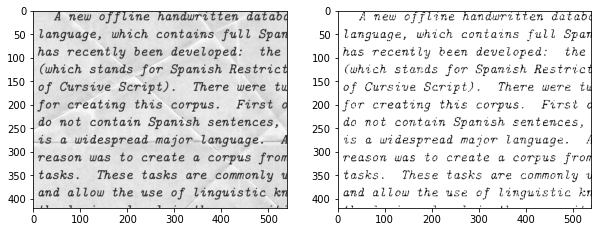

In [48]:
sample_test = load_img(test_dir/ test_images[10], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()